# Import data

In [3]:
from Utils.Toolkit import TestGen, get_data
from Utils.Toolkit import TestSplit
import numpy as np

data = get_data()

# Very high sparsity

In [4]:
URM = data['URM_all'].tocsr()
sparsity = URM.getnnz() / (URM.shape[0] * URM.shape[1])
sparsity

0.0006972830778968816

# Cold users

In [5]:
cold_users_list = []

cold_users = 0
for i in range(len(URM.indptr)-1):
    if URM.indptr[i+1]-URM.indptr[i] == 0:
        cold_users_list.append(i)
        cold_users += 1

print(f'Total users: {len(URM.indptr)}')
print(f'Cold users: {cold_users}')
print(f'Percentage of cold users: {cold_users/len(URM.indptr)*100:.2f}%\t ')
print(f'First 10 cold users: {cold_users_list[:10]}')

Total users: 30912
Cold users: 3656
Percentage of cold users: 11.83%	 
First 10 cold users: [20, 23, 24, 26, 41, 42, 46, 48, 67, 68]


# Cold items

In [6]:
URM = URM.tocsc()
cold_items_list = []

cold_users = 0
for i in range(len(URM.indptr)-1):
    if URM.indptr[i+1]-URM.indptr[i] == 0:
        cold_items_list.append(i)
        cold_users += 1

print(f'Total items: {len(URM.indptr)}')
print(f'Cold items: {cold_users}')
print(f'Percentage of cold items: {cold_users/len(URM.indptr)*100:.2f}%')
print(f'First 10 cold items: {cold_items_list[:10]}')

Total items: 18496
Cold items: 3218
Percentage of cold items: 17.40%
First 10 cold items: [1, 3, 8, 14, 15, 16, 24, 26, 27, 31]


# Cold users in our target

In [7]:
numer_of_cold_target_users = np.sum(np.isin(np.arange(URM.shape[0]), cold_users_list))
print(f'Number of cold users in target: {numer_of_cold_target_users}')
print(f'Percentage: {numer_of_cold_target_users/URM.shape[0]*100:.2f}%')

Number of cold users in target: 3656
Percentage: 11.83%


# See users with K interactions

In [18]:
users_rated = np.zeros((URM.shape[1],), dtype=int)

URM = URM.tocsr()

for i in range(len(URM.indptr)-1):
    num_of_interaction_in_row = URM.indptr[i+1] - URM.indptr[i]
    users_rated[num_of_interaction_in_row] += 1

for i in range(len(users_rated)):
    if users_rated[i] != 0:
        print(f'{users_rated[i]} have {i} interactions')

3656 have 0 interactions
2817 have 1 interactions
1919 have 2 interactions
1776 have 3 interactions
1658 have 4 interactions
1469 have 5 interactions
1429 have 6 interactions
1230 have 7 interactions
1128 have 8 interactions
923 have 9 interactions
965 have 10 interactions
788 have 11 interactions
763 have 12 interactions
664 have 13 interactions
663 have 14 interactions
530 have 15 interactions
582 have 16 interactions
469 have 17 interactions
475 have 18 interactions
478 have 19 interactions
402 have 20 interactions
417 have 21 interactions
345 have 22 interactions
308 have 23 interactions
305 have 24 interactions
281 have 25 interactions
235 have 26 interactions
215 have 27 interactions
226 have 28 interactions
232 have 29 interactions
181 have 30 interactions
174 have 31 interactions
192 have 32 interactions
181 have 33 interactions
151 have 34 interactions
149 have 35 interactions
122 have 36 interactions
128 have 37 interactions
129 have 38 interactions
105 have 39 interactions
1

# Let's divide in bigger groups

In [25]:
first_groups = np.arange(0, 11, 5)
second_groups = np.arange(20, 101, 10)
third_groups = np.arange(100, 701, 100)
groups = np.append(first_groups, second_groups)
groups = np.append(groups, third_groups)

for i in range(len(groups) - 1):
    print(f'{groups[i]:4} < interactions < {groups[i+1]:3}: {np.sum(users_rated[groups[i]:groups[i+1]]):6} -> {np.sum(users_rated[groups[i]:groups[i+1]])/URM.shape[0]*100:.2f}%')

   0 < interactions <   5:  11826 -> 38.26%
   5 < interactions <  10:   6179 -> 19.99%
  10 < interactions <  20:   6377 -> 20.63%
  20 < interactions <  30:   2966 -> 9.60%
  30 < interactions <  40:   1512 -> 4.89%
  40 < interactions <  50:    839 -> 2.71%
  50 < interactions <  60:    487 -> 1.58%
  60 < interactions <  70:    262 -> 0.85%
  70 < interactions <  80:    155 -> 0.50%
  80 < interactions <  90:     93 -> 0.30%
  90 < interactions < 100:     65 -> 0.21%
 100 < interactions < 100:      0 -> 0.00%
 100 < interactions < 200:    134 -> 0.43%
 200 < interactions < 300:     11 -> 0.04%
 300 < interactions < 400:      1 -> 0.00%
 400 < interactions < 500:      2 -> 0.01%
 500 < interactions < 600:      1 -> 0.00%
 600 < interactions < 700:      1 -> 0.00%


# Plot some items stuff

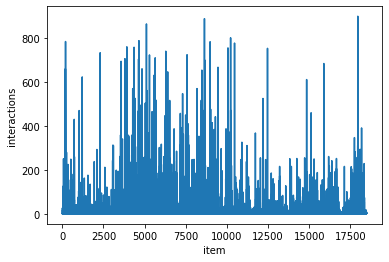

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
y_axis = []
x_axis = np.arange(URM.shape[1])
URM = URM.tocsc()

for i in range(len(URM.indptr)-1):
    value = URM.indptr[i+1]-URM.indptr[i]
    y_axis.append(value)

plt.plot(x_axis, y_axis)
plt.xlabel('item')
plt.ylabel('interactions')
plt.show()

# ---------------------------------------------------------------------------------
# ICMs

In [27]:
ICM_asset = data['ICM_asset']
ICM_price = data['ICM_price']
ICM_subclass = data['ICM_subclass']
print(ICM_asset.shape)
print(ICM_price.shape)
print(ICM_subclass.shape)

(18495, 1)
(18495, 1)
(18495, 2011)


# ICM asset

In [28]:
print(f'Sparsity {ICM_asset.getnnz() / (ICM_asset.shape[0]*ICM_asset.shape[1])*100:.2f}%')

Sparsity 99.99%


# ICM price

In [29]:
print(f'Sparsity {ICM_price.getnnz() / (ICM_price.shape[0]*ICM_price.shape[1])*100:.2f}%')

Sparsity 99.99%


# ICM subclass

In [30]:
print(f'Sparsity {ICM_subclass.getnnz() / (ICM_subclass.shape[0]*ICM_subclass.shape[1])*100:.2f}%')

Sparsity 0.05%


# ---------------------------------------------------------------------------------
# UCMs

In [31]:
UCM_region = data['UCM_region']
UCM_age = data['UCM_age']
print(UCM_region.shape)
print(UCM_age.shape)

(30911, 8)
(30910, 11)


# UCM region
#### Since sparsity is very high we can make good use of this data in a UserContentBasedRec

In [32]:
print(f'Sparsity {UCM_region.getnnz() / (UCM_region.shape[0]*UCM_region.shape[1])*100:.2f}%')

Sparsity 10.76%


# UCM age
#### Since sparsity is very high we can make good use of this data in a UserContentBasedRec

In [33]:
print(f'Sparsity {UCM_age.getnnz() / (UCM_age.shape[0]*UCM_age.shape[1])*100:.2f}%')

Sparsity 8.92%


# Pandas testing

In [41]:
import pandas as pd

URM_df = pd.read_csv('./data/data_train.csv')

<30911x18495 sparse matrix of type '<class 'numpy.float64'>'
	with 398636 stored elements in Compressed Sparse Column format>

In [40]:
grouped = URM_df.groupby('row', as_index=True).apply(lambda x: list(x['col']))
grouped

row
0             [3568, 3827, 4844, 5734, 6518, 16373, 18343]
1                  [3537, 8473, 8475, 15971, 16145, 17587]
2        [736, 1425, 3653, 4634, 4653, 5731, 14979, 149...
3                                                   [3730]
4             [543, 663, 664, 666, 1172, 4657, 4658, 9695]
                               ...                        
30905    [75, 127, 3537, 3539, 3541, 3891, 4397, 4416, ...
30906    [1400, 1411, 2301, 4197, 4634, 5074, 5196, 992...
30908    [187, 3088, 3653, 3789, 3838, 3839, 3922, 3952...
30909                     [207, 4482, 15139, 17367, 18193]
30910    [126, 127, 189, 234, 246, 550, 566, 647, 660, ...
Length: 27255, dtype: object

In [62]:
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
from random import randint, random, uniform

def split_randomic_all_users(URM, URM_df):
    selected_users = np.array([])
    available_users = np.arange(URM.shape[0])
    
    target_users = data['target_users']
    
    for user_id in available_users:
        if user_id not in target_users:
            selected_users = np.append(selected_users, user_id)
    
    target_users = selected_users.astype(int)
    grouped = URM_df.groupby('row', as_index=True).apply(lambda x: list(x['col']))
    relevant_items = defaultdict(list)
    
    for user_id in selected_users:
        # tracks corrisponde alle tracce all'index della playlist_id
        items = np.array(grouped[user_id])
            
        # Numero di tracks nella riga da rimuovere (Il 20% andrà nel test che corrisponde alle tracks rimosse)
        to_be_removed = int(len(items) * 0.2)
        for i in range(to_be_removed):
            index = randint(0, len(items) - 1)
            removed_item = items[index]
            relevant_items[user_id].append(removed_item)
            items = np.delete(items, index)
        grouped[user_id] = items

    all_items = URM_df["col"].unique()

    matrix = MultiLabelBinarizer(classes=all_items, sparse_output=True).fit_transform(grouped)
    URM_train = matrix.tocsr()
    URM_train = URM_train.astype(np.float64)
    dict_test = relevant_items
    
    return URM_train, dict_test

In [63]:
train, dict_rel = split_randomic_all_users(URM.copy(), URM_df)

In [64]:
type(test)

scipy.sparse.csr.csr_matrix

In [65]:
type(dict_rel)

collections.defaultdict

In [66]:
train.todense()

matrix([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 1.]])

In [67]:
dict_rel

defaultdict(list,
            {73.0: [6289, 7581, 5897],
             101.0: [9477],
             147.0: [15253, 197],
             154.0: [4410, 16584, 4696, 173],
             218.0: [4472, 4067, 13172, 10227],
             222.0: [7824, 7661, 5553, 5275],
             247.0: [13206, 189],
             251.0: [876],
             272.0: [5593],
             287.0: [4360, 6292, 7500, 1036, 17873, 6763],
             295.0: [10268,
              11214,
              566,
              4778,
              8890,
              4784,
              9820,
              8213,
              1041,
              15109,
              5112],
             297.0: [144, 3827],
             299.0: [6156, 5144],
             303.0: [7298],
             309.0: [15100],
             312.0: [4070],
             322.0: [9448],
             335.0: [6309],
             347.0: [5707, 4065, 4070, 9106, 16206],
             354.0: [13011, 529, 8397, 5128],
             355.0: [18292,
              640,
         

In [111]:
recommended_items = [100, 200, 300, 500, 400, 100, 3]
relevant_items = [3, 0, 0, 0, 0, 0, 0]
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False, False, False, False, False, False,  True])

In [112]:
path_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32)
path_at_k

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [113]:
tot = (1 + np.arange(is_relevant.shape[0]))
tot

array([1, 2, 3, 4, 5, 6, 7])

In [114]:
values = path_at_k / tot
values

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14285714])

In [115]:
np.sum(values) / len(relevant_items)

0.02040816326530612

In [116]:
np.min([len(relevant_items), is_relevant.shape[0]])

7

In [119]:
from sklearn.metrics import average_precision_score

average_precision_score(path_at_k, values)

1.0